In [1]:
import torch
from torch import nn

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from utils import simulate_stock_price
from utils import numpy_sequence_target

from torch.utils.data import DataLoader, TensorDataset

In [629]:
FROM = 0
TO = 5
NUM = 200

x_axis = np.linspace(FROM, TO, num= NUM)
y_axis = np.sin(np.linspace(FROM, TO, num= NUM)) * 10

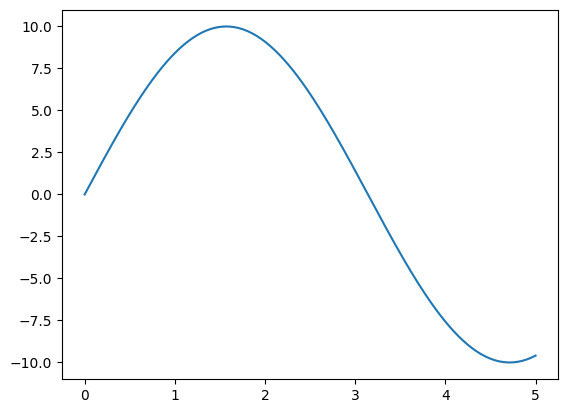

In [630]:
plt.plot(x_axis, y_axis)
plt.show()

In [631]:
# get sequences and targets from time series
X_raw, y_raw = numpy_sequence_target(y_axis, sequence_length= 5)

In [632]:
print(X_raw.shape, y_raw.shape)

(195, 5, 1) (195,)


In [633]:
# split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size= 0.1, shuffle= False)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_tens = torch.tensor(X_train, dtype= torch.float32)
y_tens = torch.tensor(y_train, dtype= torch.float32)

X_tens_test = torch.tensor(X_test, dtype= torch.float32)
y_tens_test = torch.tensor(y_test, dtype= torch.float32)

print(X_tens.shape, y_tens.shape)
print(X_tens_test.shape, y_tens_test.shape)

# Wrap dataset
dataset = TensorDataset(X_tens, y_tens)
# Create DataLoader with batching
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

(175, 5, 1) (20, 5, 1) (175,) (20,)
torch.Size([175, 5, 1]) torch.Size([175])
torch.Size([20, 5, 1]) torch.Size([20])


In [501]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, number_layers, **kwargs):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.number_layers = number_layers
        
        self.layer_1 = nn.LSTM(self.input_size, self.hidden_size, self.number_layers, **kwargs)

        # use linear layer to produce one out feature        
        # if hidden_size > 1:
        #     self.layer_2 = nn.Linear(in_features= self.hidden_size, out_features=1, bias= False)

    def forward(self, x):
        output, (hn, cn) = self.layer_1(x)

        return output, (hn, cn)
        # if self.hidden_size > 1:
        #     # (D ∗ num_layers, N, H_out) drop first dimension 
        #     return self.layer_2(hn.squeeze(0))
        # else:
        #     return hn

In [463]:
lstm = SimpleLSTM(1, 1, 1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params= lstm.parameters(), lr= 0.01)

In [464]:
EPOCHS = 1000
lstm.train()
for epoch in range(EPOCHS):

    # accumulated from all batches in an epoch
    loss = 0
    for X, y in dataloader: # X from data loader is (batch_size, sequence_length, features)
        # forward pass
        output, (hn, cn) = lstm(X.permute(1, 0, 2))
        last_output = output[-1]
        # loss function
        loss += loss_fn(last_output, y.unsqueeze(-1))
        
    # zero out gradients
    optimizer.zero_grad()
    # backpropagation
    loss.backward()
    # update parameters
    optimizer.step()

    if epoch % 100 == 0:
        with torch.inference_mode():
            output, (hn, cn) = lstm(X_tens_test.permute(1, 0, 2))
            last_output = output[-1]
            test_loss = loss_fn(last_output, y_tens_test.unsqueeze(-1))
        
        print(f'Epoch: {(epoch+1):5} | Loss: {loss:4.2f} | Test Loss: {test_loss:4.5f}')
        
        

Epoch:     1 | Loss: 17.65 | Test Loss: 0.24817
Epoch:   101 | Loss: 0.76 | Test Loss: 0.08836
Epoch:   201 | Loss: 0.28 | Test Loss: 0.06794
Epoch:   301 | Loss: 0.21 | Test Loss: 0.05867
Epoch:   401 | Loss: 0.16 | Test Loss: 0.04691
Epoch:   501 | Loss: 0.13 | Test Loss: 0.03789
Epoch:   601 | Loss: 0.11 | Test Loss: 0.03130
Epoch:   701 | Loss: 0.09 | Test Loss: 0.02598
Epoch:   801 | Loss: 0.08 | Test Loss: 0.02222
Epoch:   901 | Loss: 0.07 | Test Loss: 0.01917


In [470]:
TO_TEST = TO + 1

x_real = np.linspace(FROM, TO_TEST, num= 100)
y_real = np.sin(np.linspace(FROM, TO_TEST, num= 100))

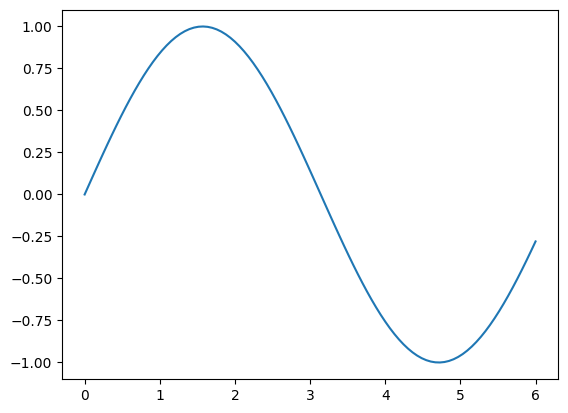

In [471]:
plt.plot(x_real, y_real)
plt.show()

In [472]:
print(x_real[5:].shape)

(95,)


In [473]:
sequences, targets = numpy_sequence_target(y_real, sequence_length= 5)
print(sequences.shape)

(95, 5, 1)


In [474]:
X_input_eval = torch.tensor(sequences, dtype= torch.float32, requires_grad= False).permute(1, 0, 2)
print(X_input_eval.shape)

torch.Size([5, 95, 1])


In [475]:
_, (hn, _) = lstm(X_input_eval)

In [476]:
y_hat = hn.flatten().detach().numpy()

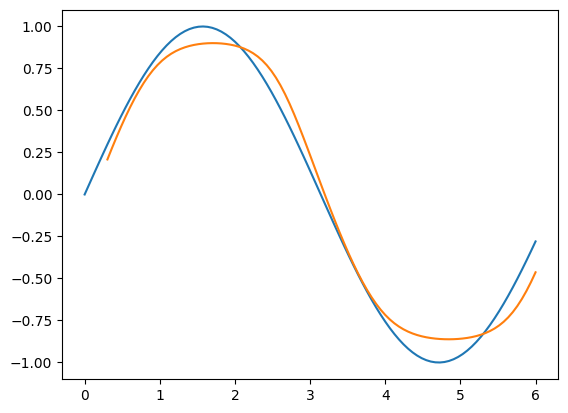

In [477]:
x_hat = x_real[5:]

plt.plot(x_real, y_real, label= 'real')
plt.plot(x_hat, y_hat, label= 'forecast')
plt.show()

In [634]:
class TestLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, number_layers, **kwargs):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.number_layers = number_layers
        
        self.layer_1 = nn.LSTM(self.input_size, self.hidden_size, self.number_layers, **kwargs)

        self.layer_2 = nn.Linear(1,1)
        
        # use linear layer to produce one out feature        
        # if hidden_size > 1:
        #     self.layer_2 = nn.Linear(in_features= self.hidden_size, out_features=1, bias= False)

    def forward(self, x):
        output, (hn, cn) = self.layer_1(x)
        linear_output = self.layer_2(hn[-1])
        return output, (hn, cn), linear_output
        # if self.hidden_size > 1:
        #     # (D ∗ num_layers, N, H_out) drop first dimension 
        #     return self.layer_2(hn.squeeze(0))
        # else:
        #     return hn

In [646]:
lstm_test = TestLSTM(1, 1, 1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params= lstm_test.parameters(), lr= 0.01)

In [647]:
## LSTM with Linear layer for mappying numbers outside of [-1,1]

In [648]:
EPOCHS = 3000
lstm.train()
for epoch in range(EPOCHS):

    # accumulated from all batches in an epoch
    loss = 0
    for X, y in dataloader: # X from data loader is (batch_size, sequence_length, features)
        # forward pass
        output, (hn, cn), linear_output = lstm_test(X.permute(1, 0, 2))
        last_output = linear_output
        # loss function
        loss += loss_fn(last_output, y.unsqueeze(-1))
        
    # zero out gradients
    optimizer.zero_grad()
    # backpropagation
    loss.backward()
    # update parameters
    optimizer.step()

    if epoch % 100 == 0:
        with torch.inference_mode():
            output, (hn, cn), linear_output = lstm_test(X_tens_test.permute(1, 0, 2))
            last_output = linear_output
            test_loss = loss_fn(last_output, y_tens_test.unsqueeze(-1))
        
        print(f'Epoch: {(epoch+1):5} | Loss: {loss:4.2f} | Test Loss: {test_loss:4.5f}')
        
        

Epoch:     1 | Loss: 1000.69 | Test Loss: 83.54092
Epoch:   101 | Loss: 743.12 | Test Loss: 98.43761
Epoch:   201 | Loss: 566.87 | Test Loss: 109.87241
Epoch:   301 | Loss: 286.43 | Test Loss: 61.17945
Epoch:   401 | Loss: 192.51 | Test Loss: 51.75803
Epoch:   501 | Loss: 133.73 | Test Loss: 43.18568
Epoch:   601 | Loss: 94.21 | Test Loss: 35.49410
Epoch:   701 | Loss: 68.28 | Test Loss: 28.82077
Epoch:   801 | Loss: 48.58 | Test Loss: 23.18575
Epoch:   901 | Loss: 35.52 | Test Loss: 18.54211
Epoch:  1001 | Loss: 27.37 | Test Loss: 14.82312
Epoch:  1101 | Loss: 19.14 | Test Loss: 11.85633
Epoch:  1201 | Loss: 15.48 | Test Loss: 9.51128
Epoch:  1301 | Loss: 10.95 | Test Loss: 7.67176
Epoch:  1401 | Loss: 8.61 | Test Loss: 6.21607
Epoch:  1501 | Loss: 6.75 | Test Loss: 5.06996
Epoch:  1601 | Loss: 5.28 | Test Loss: 4.15458
Epoch:  1701 | Loss: 4.32 | Test Loss: 3.43829
Epoch:  1801 | Loss: 3.54 | Test Loss: 2.86454
Epoch:  1901 | Loss: 2.94 | Test Loss: 2.39521
Epoch:  2001 | Loss: 2.49 

In [649]:
TO_TEST = TO + 1

In [650]:
x_real = np.linspace(FROM, TO_TEST, num= 100)
y_real = np.sin(np.linspace(FROM, TO_TEST, num= 100)) * 10

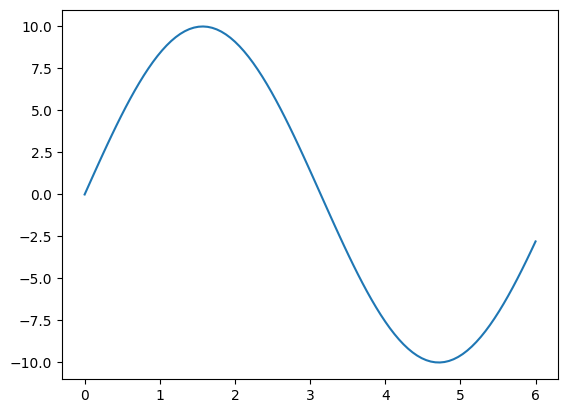

In [651]:
plt.plot(x_real, y_real)
plt.show()

In [652]:
print(x_real[5:].shape)

(95,)


In [653]:
sequences, targets = numpy_sequence_target(y_real, sequence_length= 5)
print(sequences.shape)

(95, 5, 1)


In [654]:
X_input_eval = torch.tensor(sequences, dtype= torch.float32, requires_grad= False).permute(1, 0, 2)
print(X_input_eval.shape)

torch.Size([5, 95, 1])


In [655]:
_, (hn, _), linear_output = lstm_test(X_input_eval)

In [656]:
y_hat = linear_output.flatten().detach().numpy()

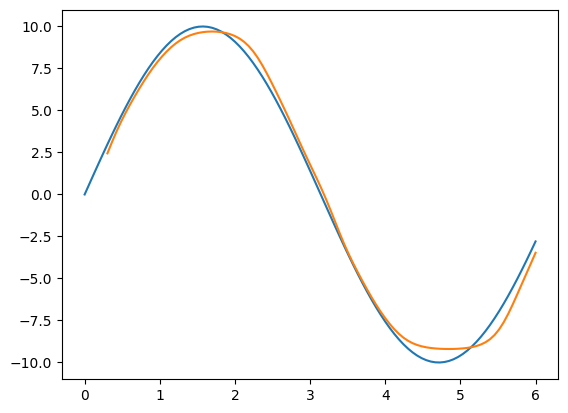

In [657]:
x_hat = x_real[5:]

plt.plot(x_real, y_real, label= 'real')
plt.plot(x_hat, y_hat, label= 'forecast')
plt.show()

In [716]:
x_test_eval = np.linspace(0, 20, num= 100)
y_test_eval = np.sin(np.linspace(0, 20, num= 100)) * 10

In [717]:
sequences, targets = numpy_sequence_target(y_test_eval, sequence_length= 5)
print(sequences.shape)

(95, 5, 1)


In [718]:
X_input_eval = torch.tensor(sequences, dtype= torch.float32, requires_grad= False).permute(1, 0, 2)
print(X_input_eval.shape)

torch.Size([5, 95, 1])


In [719]:
_, (hn, _), linear_output = lstm_test(X_input_eval)

In [720]:
y_hat = linear_output.flatten().detach().numpy()

In [721]:
x_hat = x_test_eval[5:]
print(x_hat.shape, y_hat.shape)

(95,) (95,)


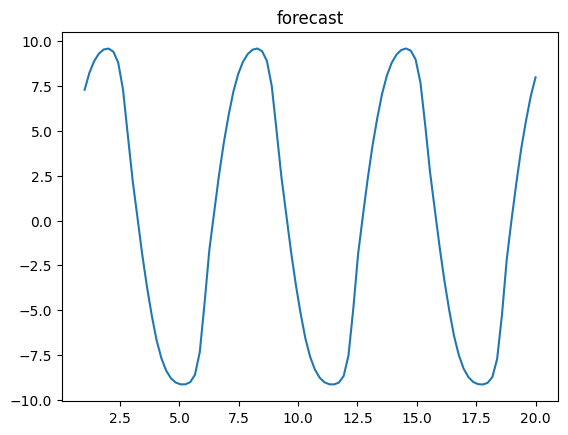

In [722]:
plt.plot(x_hat, y_hat)
plt.title('forecast')
plt.show()

In [723]:
print(x_test_eval[5:].shape, y_test_eval[5:].shape)

(95,) (95,)


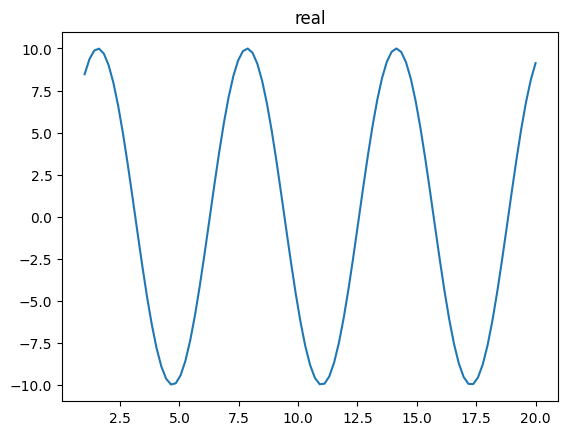

In [724]:
plt.plot(x_test_eval[5:], y_test_eval[5:])
plt.title('real')
plt.show()